In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from itertools import combinations
from pathlib import Path

In [ ]:
import time, importlib

mods = ["numpy", "scipy", "numba", "llvmlite", "sklearn", "pynndescent", "umap"]
for m in mods:
    t=time.time()
    importlib.import_module(m)
    print(f"{m:12s} -> {time.time()-t:.2f}s")


numpy        -> 0.04s
scipy        -> 0.00s
numba        -> 0.06s
llvmlite     -> 0.00s
sklearn      -> 0.48s


In [ ]:
import umap

In [25]:
!gdown 1F2sQCVgxEOV_HT1_j2NiSSw6p8XLFrwB -O data/trayectorias_educativas.csv

Downloading...
From: https://drive.google.com/uc?id=1F2sQCVgxEOV_HT1_j2NiSSw6p8XLFrwB
To: /Users/camilarojasguajardo/Desktop/Magister/trayectorias-educativas-IIC2433/data/trayectorias_educativas.csv
100%|██████████████████████████████████████| 20.2M/20.2M [00:00<00:00, 26.0MB/s]


In [6]:
CSV_PATH = os.path.join("data", "trayectorias_educativas.csv")
SAMPLE_SIZE = 10000 
IQR_MULTIPLIER = 1.5

In [7]:
dataset = pd.read_csv(CSV_PATH)
dataset

,MRUN,ANYO_PROCESO,year,DEPENDENCIA,RAMA_EDUCACIONAL,CODIGO_REGION_DOMICILIO,CODIGO_COMUNA_DOMICILIO,NOMBRE_COMUNA_DOMICILIO,INGRESO_PERCAPITA_GRUPO_FA,PTJE_NEM,...,HCSOC_MAX,CIEN_MAX,CODIGO_CARRERA,NOMBRE_CARRERA,SIGLA_UNIVERSIDAD,SEDE,VIA_ADMISION,HABILITACION_POST,BENEFICIO_BECA_FSCU,TIPO_ALUMNO
0,26105337,2024,2024,3,H1,13,13122,PEÑALOLEN,2,808.0,...,0.0,660.0,41060,ODONTOLOGIA,UNAB,SANTIAGO,1,1,Sin beneficio,No beneficiario
1,26526290,2024,2024,3,H1,6,6101,RANCAGUA,99,922.0,...,587.0,394.0,47201,INGENIERÍA CIVIL,UOH,CAMPUS RANCAGUA,1,1,Sin beneficio,No beneficiario
2,26525888,2024,2024,2,H1,5,5101,VALPARAISO,99,643.0,...,388.0,413.0,41136,INGENIERIA EN TURISMO Y HOTELERIA,UNAB,VIÑA DEL MAR,1,1,Sin beneficio,No beneficiario
3,15222242,2024,2024,6,T3,1,1101,IQUIQUE,1,901.0,...,0.0,376.0,22042,INGENIERÍA COMERCIAL MENCIÓN GESTIÓN Y/O COMER...,UTA,IQUIQUE,1,1,Sin beneficio,No beneficiario
4,17427365,2024,2024,2,H2,8,8108,SAN PEDRO DE LA PAZ,1,915.0,...,474.0,425.0,13050,NUTRICION Y DIETETICA,UDEC,CONCEPCION,4,2,GRATUIDAD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130538,27420484,2024,2024,,,13,13129,SAN JOAQUIN,5,0.0,...,0.0,581.0,43013,INGENIERÍA CIVIL (PLAN COMÚN),UANDES,SANTIAGO,3,1,Sin beneficio,No beneficiario
130539,27582341,2024,2024,3,H1,13,13131,SAN RAMON,2,928.0,...,0.0,502.0,56219,NUTRICIÓN Y DIETÉTICA,UDLA,SANTIAGO CENTRO,1,1,Sin beneficio,No beneficiario
130540,27582436,2024,2024,3,H1,15,15101,ARICA,1,657.0,...,430.0,407.0,22007,TRABAJO SOCIAL,UTA,ARICA,1,1,Sin beneficio,No beneficiario
130541,27582865,2024,2024,3,T1,5,5801,QUILPUE,5,433.0,...,312.0,0.0,50802,DERECHO,USS,SANTIAGO,1,1,Sin beneficio,No beneficiario


In [8]:
print("Filas:", len(dataset))
print("Columnas:", dataset.columns)

Filas: 130543
Columnas: Index(['MRUN', 'ANYO_PROCESO', 'year', 'DEPENDENCIA', 'RAMA_EDUCACIONAL',
       'CODIGO_REGION_DOMICILIO', 'CODIGO_COMUNA_DOMICILIO',
       'NOMBRE_COMUNA_DOMICILIO', 'INGRESO_PERCAPITA_GRUPO_FA', 'PTJE_NEM',
       'PTJE_RANKING', 'CLEC_MAX', 'MATE1_MAX', 'MATE2_MAX', 'HCSOC_MAX',
       'CIEN_MAX', 'CODIGO_CARRERA', 'NOMBRE_CARRERA', 'SIGLA_UNIVERSIDAD',
       'SEDE', 'VIA_ADMISION', 'HABILITACION_POST', 'BENEFICIO_BECA_FSCU',
       'TIPO_ALUMNO'],
      dtype='object')


# Asignación de tipos correctos a columnas

In [ ]:
# 1. Cadenas (identificadores y texto)
cols_str = [
    "MRUN", "DEPENDENCIA", "RAMA_EDUCACIONAL", "NOMBRE_COMUNA_DOMICILIO",
    "NOMBRE_CARRERA", "SIGLA_UNIVERSIDAD", "SEDE",
    "VIA_ADMISION", "HABILITACION_POST", "BENEFICIO_BECA_FSCU", "TIPO_ALUMNO"
]
for c in cols_str:
    if c in dataset.columns:
        dataset[c] = dataset[c].astype("string").str.strip()

# 2. Numéricas enteras (códigos o años)
cols_int = [
    "ANYO_PROCESO", "year", "CODIGO_REGION_DOMICILIO",
    "CODIGO_COMUNA_DOMICILIO", "CODIGO_CARRERA"
]
for c in cols_int:
    if c in dataset.columns:
        dataset[c] = pd.to_numeric(dataset[c], errors="coerce").astype("Int64")

# 3. Numéricas continuas (puntajes, ingresos)
cols_float = [
    "INGRESO_PERCAPITA_GRUPO_FA", "PTJE_NEM", "PTJE_RANKING",
    "CLEC_MAX", "MATE1_MAX", "MATE2_MAX", "HCSOC_MAX", "CIEN_MAX"
]
for c in cols_float:
    if c in dataset.columns:
        dataset[c] = pd.to_numeric(dataset[c], errors="coerce")

# 4. Verificación de tipos
print(dataset.dtypes)


MRUN                          string[python]
ANYO_PROCESO                           Int64
year                                   Int64
DEPENDENCIA                   string[python]
RAMA_EDUCACIONAL              string[python]
CODIGO_REGION_DOMICILIO                Int64
CODIGO_COMUNA_DOMICILIO                Int64
NOMBRE_COMUNA_DOMICILIO       string[python]
INGRESO_PERCAPITA_GRUPO_FA             int64
PTJE_NEM                             float64
PTJE_RANKING                         float64
CLEC_MAX                             float64
MATE1_MAX                            float64
MATE2_MAX                            float64
HCSOC_MAX                            float64
CIEN_MAX                             float64
CODIGO_CARRERA                         Int64
NOMBRE_CARRERA                string[python]
SIGLA_UNIVERSIDAD             string[python]
SEDE                          string[python]
VIA_ADMISION                  string[python]
HABILITACION_POST             string[python]
BENEFICIO_

# PCA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,


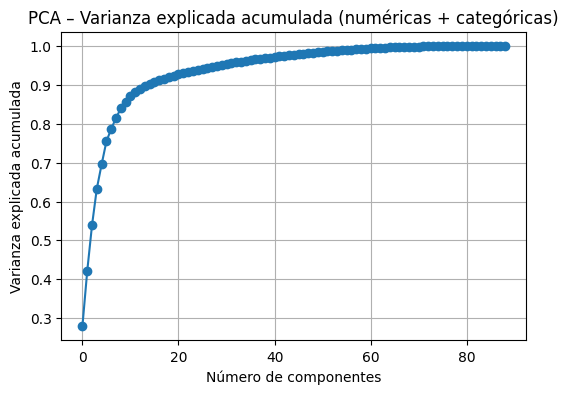

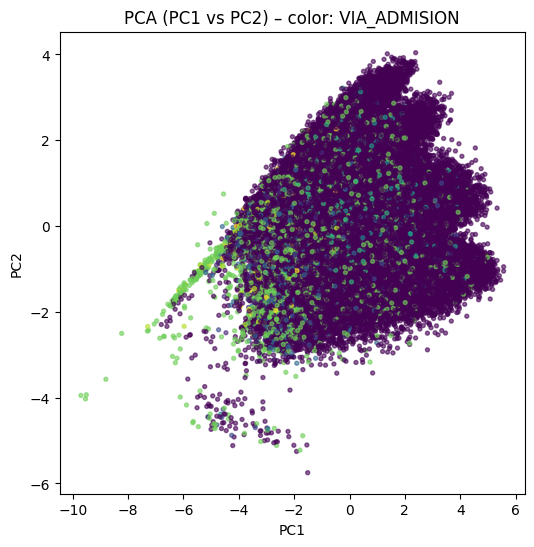

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ----------------------------
# 1️⃣ Definir columnas por tipo
# ----------------------------
num_cols = [
    "INGRESO_PERCAPITA_GRUPO_FA",
    "PTJE_NEM","PTJE_RANKING",
    "CLEC_MAX","MATE1_MAX","MATE2_MAX","HCSOC_MAX","CIEN_MAX"
]

cat_cols = [
    "DEPENDENCIA","VIA_ADMISION","BENEFICIO_BECA_FSCU","TIPO_ALUMNO","SIGLA_UNIVERSIDAD"
]

num_cols = [c for c in num_cols if c in dataset.columns]
cat_cols = [c for c in cat_cols if c in dataset.columns]

# -------------------------------------
# 2️⃣ Preprocesamiento conjunto
# -------------------------------------
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_pre = preproc.fit_transform(dataset)

# -------------------------------------
# 3️⃣ PCA con todas las variables
# -------------------------------------
pca = PCA()
X_pca = pca.fit_transform(X_pre)

# Varianza explicada
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("PCA – Varianza explicada acumulada (numéricas + categóricas)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.grid(True)
plt.show()

# -------------------------------------
# 4️⃣ Visualización PC1 vs PC2
# -------------------------------------
color_col = "VIA_ADMISION" if "VIA_ADMISION" in dataset.columns else None
if color_col:
    color_codes = dataset[color_col].astype("category").cat.codes
else:
    color_codes = None

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=color_codes, s=8, cmap="viridis", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA (PC1 vs PC2) – color: {color_col}")
plt.show()


In [18]:
var_acum = np.cumsum(pca.explained_variance_ratio_)

# Número de componentes que alcanzan 90%
n_comp_90 = np.argmax(var_acum >= 0.90) + 1

print(f"🔹 Número de componentes que explican al menos el 90% de la varianza: {n_comp_90}")
print(f"🔹 Varianza explicada acumulada por esos componentes: {var_acum[n_comp_90-1]:.3f}")

🔹 Número de componentes que explican al menos el 90% de la varianza: 15
🔹 Varianza explicada acumulada por esos componentes: 0.904


# Normalizacion de los datos

In [194]:
df = pd.get_dummies(df, drop_first=True, dummy_na=True)
print(f"Columnas después de get_dummies: {df.shape[1]}")

# Asegurar que todas las columnas sean numéricas
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Estandarización (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
print("Normalización lista")

Columnas después de get_dummies: 10781
Normalización lista


In [195]:
X_scaled = df.apply(lambda s: s.fillna(s.median()))

In [196]:
X_scaled.head()

,MRUN,ANYO_PROCESO_x,CODIGO_CARRERA,PREFERENCIA,PUNTAJE_PONDERADO,LUGAR_EN_LA_LISTA,VIA_INGRESO,ANYO_PROCESO_y,COD_SEXO,FECHA_NACIMIENTO_x,...,MATE2_INV_ANTERIOR_434,MATE2_INV_ANTERIOR_463,MATE2_INV_ANTERIOR_495,MATE2_INV_ANTERIOR_518,MATE2_INV_ANTERIOR_532,MATE2_INV_ANTERIOR_580,MATE2_INV_ANTERIOR_599,MATE2_INV_ANTERIOR_626,MATE2_INV_ANTERIOR_654,MATE2_INV_ANTERIOR_nan
160188,4716599,2025,16005,2,817.15,9,1,2025.0,2.0,200605.0,...,False,False,False,False,False,False,False,False,False,False
4386,22473476,2024,38083,3,746.80,39,1,2024.0,1.0,200411.0,...,False,False,False,False,False,False,False,False,False,True
11906,3255544,2024,50807,1,696.75,47,1,2024.0,1.0,200512.0,...,False,False,False,False,False,False,False,False,False,True
229490,17372710,2025,41168,1,710.20,29,1,2025.0,2.0,200505.0,...,False,False,False,False,False,False,False,False,False,False
116182,8350855,2024,42003,1,789.50,64,1,2024.0,1.0,200505.0,...,False,False,False,False,False,False,False,False,False,True


In [197]:
list(X_scaled.columns)

['MRUN',
 'ANYO_PROCESO_x',
 'CODIGO_CARRERA',
 'PREFERENCIA',
 'PUNTAJE_PONDERADO',
 'LUGAR_EN_LA_LISTA',
 'VIA_INGRESO',
 'ANYO_PROCESO_y',
 'COD_SEXO',
 'FECHA_NACIMIENTO_x',
 'PROMEDIO_NOTAS',
 'PTJE_NEM',
 'PORC_SUP_NOTAS',
 'PTJE_RANKING',
 'CLEC_REG_ACTUAL',
 'MATE1_REG_ACTUAL',
 'MATE2_REG_ACTUAL',
 'HCSOC_REG_ACTUAL',
 'CIEN_REG_ACTUAL',
 'CLEC_INV_ACTUAL',
 'MATE1_INV_ACTUAL',
 'MATE2_INV_ACTUAL',
 'HCSOC_INV_ACTUAL',
 'CIEN_INV_ACTUAL',
 'CLEC_REG_ANTERIOR',
 'MATE1_REG_ANTERIOR',
 'MATE2_REG_ANTERIOR',
 'HCSOC_REG_ANTERIOR',
 'CIEN_REG_ANTERIOR',
 'CLEC_INV_ANTERIOR',
 'MATE_INV_ANTERIOR',
 'HCSOC_INV_ANTERIOR',
 'CIEN_INV_ANTERIOR',
 'CLEC_MAX',
 'MATE1_MAX',
 'MATE2_MAX',
 'HCSOC_MAX',
 'CIEN_MAX',
 'RINDIO_PROCESO_ANTERIOR',
 'RINDIO_PROCESO_ACTUAL',
 'HABILITACION_POST',
 'FORMA_REG_CL',
 'CORRECTAS_REG_CL',
 'ERRADAS_REG_CL',
 'OMITIDAS_REG_CL',
 'FORMA_REG_M1',
 'CORRECTAS_REG_M1',
 'ERRADAS_REG_M1',
 'OMITIDAS_REG_M1',
 'FORMA_REG_M2',
 'CORRECTAS_REG_M2',
 'ERRADAS_

# Detección de outliers

In [198]:
col = ["PUNTAJE_PONDERADO", "PTJE_RANKING", "PTJE_NEM"]

Q1 = X_scaled[col].quantile(0.25)
Q3 = X_scaled[col].quantile(0.75)
IQR = Q3 - Q1
k = 1.5  # puedes ajustar si quieres más o menos permisivo

lower = Q1 - k * IQR
upper = Q3 + k * IQR

mask = pd.DataFrame(True, index=X_scaled.index, columns=col)
for c in col:
    mask[c] = (df[c] >= lower[c]) & (df[c] <= upper[c])


mask_final = mask.all(axis=1)
df_clean = X_scaled.loc[mask_final].copy()

print(f"Outliers eliminados según {col}: {len(df) - len(df_clean)} / {len(df)} "
      f"({100*(1-len(df_clean)/len(df))}%)")

Outliers eliminados según ['PUNTAJE_PONDERADO', 'PTJE_RANKING', 'PTJE_NEM']: 1058 / 10000 (10.58%)


# Correlacion

# Reducción dimensionalidad: PCA

# Visualización: UMAP